In [199]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

In [ ]:
def simulacao_percolacao(N, p):
    percolou = False
    maior_cluster = 0
    num_clusters = 0

    grade = np.random.rand(N, N) < p
    grade = np.where(grade, 1, 0)

    if not np.any(grade):
        return False, 0, 0
    # Se a matriz for inteiramente de zeros, já retorna que não percola e não teve clusters

    estrutura = ndimage.generate_binary_structure(rank=2, connectivity=1)
    # Define a estrutura de Vizinhos de von Neumann

    grade_clusters, num_clusters = ndimage.label(grade, estrutura)
    # Função de etiquetar as matrizes em clusters

    coluna_1 = grade_clusters[:, 0]
    coluna_n = grade_clusters[:, -1]
    linha_1 = grade_clusters[0]
    linha_n = grade_clusters[-1]

    intersecoes_vertical = np.intersect1d(linha_1, linha_n)
    intersecoes_horizontal = np.intersect1d(coluna_1, coluna_n)
    percolou_vertical = np.any(intersecoes_vertical > 0)
    percolou_horizontal = np.any(intersecoes_horizontal > 0)
    if percolou_vertical or percolou_horizontal:
        percolou = True

    grade_clusters_d1 = np.ravel(grade_clusters)
    contagem = np.bincount(grade_clusters_d1)
    # Conta ocupação de cada etiqueta de cluster
    maior_cluster = max(contagem[1:])
    # Maior cluster é o elemento que ocupou mais sítios (excluindo o zero)

    return percolou, maior_cluster, num_clusters

perc, maior, num = simulacao_percolacao(6, 0.5)
print(f"O sistema percolou? {perc}")
print(f"Qual o tamanho do maior cluster? {maior}")
print(f"Qual o número total de clusters? {num}")


O sistema percolou? True
Qual o tamanho do maior cluster? 14
Qual o número total de clusters? 4


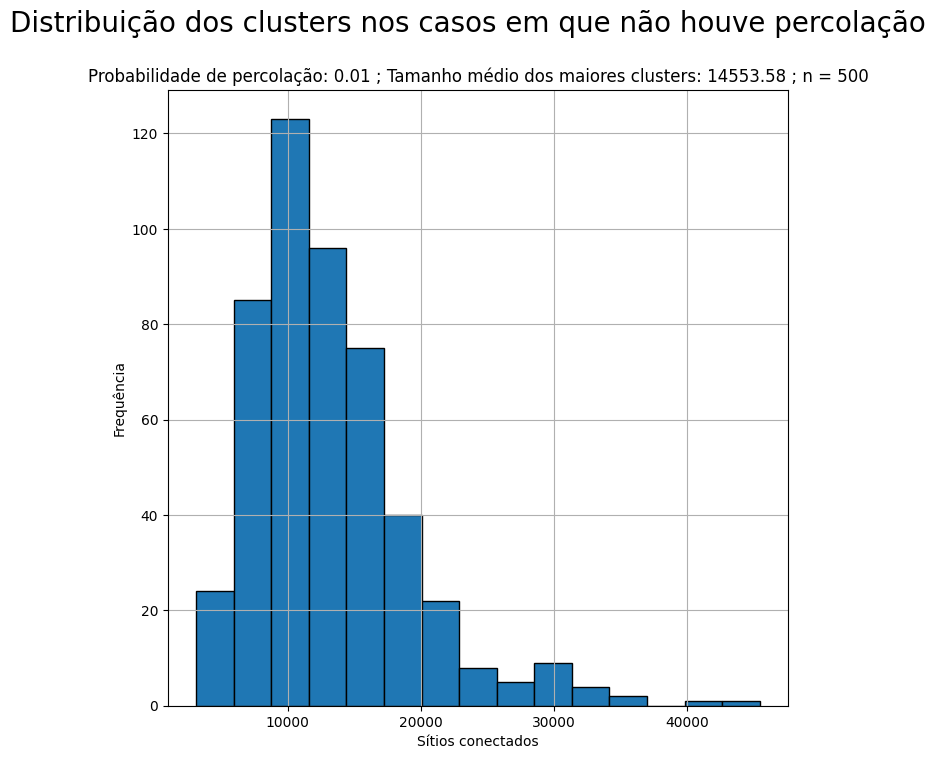

(0.01, '14553.58')

In [227]:
# Função que calcula tanto a probabilidade de percolação dado N, p e n quanto a média do maior cluster

def prob_percolacao_e_media_cluster(N, p, n):
  valores_cluster = []
  per, soma, nao_percola = 0, 0, 0
  for i in range(n):
    y = simulacao_percolacao(N, p)
    if y[0] == True:
      per += 1
    else:
      nao_percola += 1
      soma += y[1]
      valores_cluster.append(y[1])
  if nao_percola == 0:
    media = 0
  else:
    media = soma/nao_percola
  plt.figure(figsize=(8,8))
  plt.hist(valores_cluster, align='left', edgecolor='black', bins=15)
  plt.suptitle('Distribuição dos clusters nos casos em que não houve percolação', size=20)
  plt.title(f'Probabilidade de percolação: {per/n} ; Tamanho médio dos maiores clusters: {media:.2f} ; n = {n}')
  plt.xlabel('Sítios conectados')
  plt.ylabel('Frequência')
  plt.grid(True)
  plt.show()
  return per/n, f'{media:.2f}'

prob_percolacao_e_media_cluster(512, 0.58, 500)